In [1]:
import itertools
import sys, os

import numpy as np
import pandas as pd
from scipy.special import comb
from scipy import stats
import scipy.cluster.hierarchy as hac
import matplotlib.pyplot as plt
plt.style.use('classic')
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns

from collections import Counter
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

sns.set(rc={'figure.figsize':(15,8)})
sns.set_context('poster')

In [2]:
%load_ext autoreload
%autoreload 2
#import CCPA_lib as cp


In [3]:
sns.set_context('poster')

### Catalytic Promiscuity in the Biosynthesis of Cyclic Peptide in Planktonic Marine Cyanobacteria, PNAS2010
Detection of procM and procA gene sequences in marine cyanobacterial genomes.
1. **procM** gene sequences were detected in marine cyanobacterial genomes using the **pre-computed phylogenetic tree viewer in the microbesonline database** (http://www.microbesonline.org (3), which is computed using FastBLAST (4), see http://www.microbesonline.org/treebrowseHelp.html for additional details). 
2. **procA** sequences were detected in the genomes of Prochlorococcus **MIT9313** by **manually searching for short ORFs close to the procM gene** that encoded a **peptide** with a **leader sequence** followed by a **double-glycine** protease recognition site and a **short** core peptide rich in **Cys, Ser and Thr** residues (Fig. 1C). 
3. Once several such putative lantipeptides were discovered, we used **BLASTp** in both **microbesonline** and the **NCBI nr** database (with a cutoff **e-value of 10**) to detect other, similar genes in cyanobacterial genomes
4.  **manually** checked the resulting peptide sequences to verify that they agreed with the definition of procAs, as described above. 
5. Figure 1 and Figure S1 were produced using IMG (http://img.jgi.doe.gov/cgi-bin/pub/main.cgi).

### Evolutionary radiation of lanthipeptides in marine cyanobacteria, PNAPLUS 2017
1. Annotation of **prochlorosin** biosynthesis genes was performed manually using **BLAST** (12). 
2. The sequences of the **ProcM, LanT and LanOM** proteins from Prochlorococcus **MIT9313** were used as queries for the search of homologous proteins. 
3. Top hits were further inspected against the **NCBI Conserved Domain Database (CDD)** (13) to verify the presence of signature domains.
4. The **tBLASTn** algorithm was used to search **procA and procA pseudogenes** using a **consensus sequence** derived from **29 prochlorosin leader peptide** sequences from Prochlorococcus **MIT9313**. 
5. BLAST hits with **>45% identity** and **E-val <0.001** were inspected against the CDD to confirm the presence of the **nif11-like leader peptide domain**.


![](http://oregonstate.edu/instruct/bb450/fall14/stryer7/2/table_02_02.jpg)

https://www.uniprot.org/uniprot/Q7V735

http://tigrfams.jcvi.org/cgi-bin/HmmReportPage.cgi?acc=TIGR03798

https://www.ebi.ac.uk/training/online/course/interpro-functional-and-structural-analysis-protei/sequence-searching/searching-interpro-batc

http://www.ebi.ac.uk/interpro/sequencesearch/iprscan5-S20190707-131508-0462-76111813-p1m

https://www.ebi.ac.uk/Tools/services/rest/iprscan5/result/iprscan5-S20190707-131508-0462-76111813-p1m/json

In [4]:
def find_split_index(aa_sequence):
    gg_index = aa_sequence.find('GG')
    return gg_index
    ga_index = aa_sequence.find('GA')
    split_index = -1
    if gg_index == -1:
        split_index = ga_index
    elif ga_index == -1:
        split_index = gg_index
    else:
        split_index = min(gg_index, ga_index)
    return split_index
    
def analyze_procm_data(row):
    aa_sequence = str(row['aa_sequence'])
    function = str(row['function'])
    aa_length = len(aa_sequence)
    split_index = find_split_index(aa_sequence)
    core_sequence = None
    core_length = None
    count_dict = dict()
    precent_dict = dict()
    is_lanm = False
    if function == 'Lanthionine biosynthesis protein LanM':
        is_lanm = True

    if split_index != -1:
        core_sequence = aa_sequence[split_index+2:]
        core_length = len(core_sequence)
        if core_length > 0:
            count = Counter(core_sequence)
            count_dict = {f'core_count_{k}' : v for k,v in count.items()}
            precent_dict = {f'core_precent_{k}' : v/core_length for k,v in count.items()}
    return row.append(pd.Series({
        'aa_length' : aa_length,
        'split_index' : split_index,
        'core_sequence' : core_sequence,
        'core_length' : core_length,
        'is_lanm' : is_lanm,
        **count_dict, 
        **precent_dict, 
    }))

In [5]:
import subprocess
def run_diamond_to_create_db():
    dbname='pro_faa'
    cwd = os.getcwd()
    in_fasta_dpath = os.path.join(cwd, 'data', 'all_Prochlorococcus_ORFs_faa')
    
    diamond_exe = os.path.join(cwd, 'bin','diamond.exe')
    out_dpath = os.path.join(cwd,'diamond_tmp')
    diamond_params = [#'TYPE', os.path.join(in_fasta_dpath, '*'), 
                      #'|', 
                      diamond_exe, 'makedb', 
                      '--in', os.path.join(in_fasta_dpath, 'all_faa.faa'), 
                      '-d', os.path.join(out_dpath, dbname)
    ]
    try:
        os.makedirs(out_dpath, exist_ok=True)
        retcode = subprocess.check_call(' '.join(diamond_params), shell=True)
        if retcode < 0:
            print("Child was terminated by signal", -retcode)
    except OSError as e:
        print("Execution failed:", e)
    except subprocess.CalledProcessError as e:
        print("Execution failed:", e)
    


In [6]:
import subprocess
def _write_fasta(fname, sequence):
    with open(fname, 'w') as f:
        f.write(f'> tmp\n{sequence}\n')
        
def _read_diamond_results(fname):
    diamond_columns = [ 'gene_id', 'pident', 'length', 'mismatch', 'gapopen', 'qstart', 'qend', 'sstart',
                   'send', 'evalue', 'bitscore']
    dout_df = pd.read_csv(fname, sep='\t', 
                     names=diamond_columns)
    return dout_df.reset_index(drop=True)

def run_diamond_to_align_sequence(aa_sequence):
    dbname='pro_faa'
    cwd = os.getcwd()
    in_fasta_dpath = os.path.join(cwd, 'data', 'all_Prochlorococcus_ORFs_faa')
    
    diamond_exe = os.path.join(cwd, 'bin','diamond.exe')
    out_dpath = os.path.join(cwd,'diamond_tmp')
    out_fpath = os.path.join(out_dpath, 'diamond_out.txt')
    tmp_fpath = os.path.join(out_dpath, 'tmp.faa')

    os.makedirs(out_dpath, exist_ok=True)
    _write_fasta(tmp_fpath, aa_sequence)
    diamond_params = [#'TYPE', os.path.join(in_fasta_dpath, '*'), 
                      #'|', 
                      diamond_exe, 'blastp', 
                      '-q', tmp_fpath, 
                      '-d', os.path.join(out_dpath, dbname),
                      '-o', out_fpath,
    ]
    try:
        subprocess.check_call(' '.join(diamond_params), shell=True)
        return _read_diamond_results(out_fpath)
    except OSError as e:
        print("Execution failed:", e)
    except subprocess.CalledProcessError as e:
        print("Execution failed:", e)
    


In [7]:
genomes_dpath = r'data\detailed_Prochlorococcus_genome_annotations'
genome_fnames = [ n for n in os.listdir(genomes_dpath) if n.endswith('.txt')]
def _load(fname):
    df = pd.read_csv(os.path.join(genomes_dpath, fname), sep='\t')
    df['genome'] = os.path.basename(os.path.splitext(fname)[0])
    return df
genome_df = pd.concat([_load(fname) for fname in genome_fnames])


In [8]:
clades = pd.read_csv(os.path.join('data', 'clades.csv'))
clades.index = clades.Name

In [9]:
clades.head()
clades.Clade.to_dict()

{'MED4': 'HLI',
 'MIT9515': 'HLI',
 'AS9601': 'HLII',
 'MIT9202': 'HLII',
 'MIT9215': 'HLII',
 'MIT9301': 'HLII',
 'MIT9312': 'HLII',
 'UH18301': 'HLII',
 'W6': 'HLII',
 'HNLC2': 'HLIII',
 'W3': 'HLIII',
 'W5': 'HLIII',
 'W7': 'HLIII',
 'W8': 'HLIII',
 'W9': 'HLIII',
 'HNLC1': 'HLIV',
 'W10': 'HLIV',
 'W11': 'HLIV',
 'W12': 'HLIV',
 'W2': 'HLIV',
 'W4': 'HLIV',
 'NATL1A': 'LLI',
 'NATL2A': 'LLI',
 'MIT9211': 'LLII,III',
 'SS120': 'LLII,III',
 'MIT9303': 'LLIV',
 'MIT9313': 'LLIV',
 'EQPAC1': 'HLI',
 'GP2': 'HLII',
 'MIT0604': 'HLII',
 'MIT9107': 'HLII',
 'MIT9116': 'HLII',
 'MIT9123': 'HLII',
 'MIT9201': 'HLII',
 'MIT9302': 'HLII',
 'MIT9311': 'HLII',
 'MIT9314': 'HLII',
 'MIT9321': 'HLII',
 'MIT9322': 'HLII',
 'MIT9401': 'HLII',
 'SB': 'HLII',
 'MIT0801': 'LLI',
 'PAC1': 'LLI',
 'LG': 'LLII,III',
 'MIT0601': 'LLII,III',
 'MIT0602': 'LLII,III',
 'MIT0603': 'LLII,III',
 'SS2': 'LLII,III',
 'SS35': 'LLII,III',
 'SS51': 'LLII,III',
 'SS52': 'LLII,III',
 'MIT0701': 'LLIV',
 'MIT0702': 'LLI

In [10]:
genome_df['clade'] = genome_df.genome.map(clades.Clade.to_dict())

In [11]:
genome_df  = genome_df.reset_index(drop=True)

In [12]:
genome_df.head()

,contig_id,gene_id,feature_id,type,location,start,stop,strand,function,aliases,figfam,evidence_codes,nucleotide_sequence,aa_sequence,genome,clade
0,AS9601,PAS9601_0001,fig|1218.83.peg.1,peg,AS9601_168_1325,168,1325,+,DNA polymerase III beta subunit (EC 2.7.7.7),NaN,FIG00066425,isu;DNA-replication isu;DNA_replication_cluster_1,atggaaattatttgtaatcaaaatgaattaaataatgctatacaac...,MEIICNQNELNNAIQLVSKAVASRPTHPILANILLTADEGTNKISV...,AS9601,HLII
1,AS9601,PAS9601_0002,fig|1218.83.peg.2,peg,AS9601_1327_2034,1327,2034,+,RNA metabolism-related protein,NaN,NaN,NaN,ttgaaattacctaaagaaattttattaagtgaattattaaattata...,MKLPKEILLSELLNYIVKGNMVLNYGNGENVWMHPPVHRILGWYSR...,AS9601,HLII
2,AS9601,PAS9601_0003,fig|1218.83.peg.3,peg,AS9601_2038_4377,2038,4377,+,"Phosphoribosylformylglycinamidine synthase, sy...",NaN,FIG01303876,icw(1);De_Novo_Purine_Biosynthesis,atgataaatcatgaaaataatgatctatttgatcttaatgaagcat...,MINHENNDLFDLNEALKVENLTLNDYEEICKRLKRKPNRTELGMFG...,AS9601,HLII
3,AS9601,PAS9601_0004,fig|1218.83.peg.4,peg,AS9601_4425_5885,4425,5885,+,Amidophosphoribosyltransferase (EC 2.4.2.14),NaN,FIG00000179,isu;YgfZ isu;De_Novo_Purine_Biosynthesis,atgtgcggaatagttggaatcgtttcttcgaatgatgtaaatcaac...,MCGIVGIVSSNDVNQQIYDSLLLLQHRGQDSTGIATMENTVFHIHK...,AS9601,HLII
4,AS9601,PAS9601_0005,fig|1218.83.peg.5,peg,AS9601_8323_5882,8323,5882,-,DNA gyrase subunit A (EC 5.99.1.3),NaN,FIG00000080,idu(1);DNA_gyrase_subunits idu(1);DNA_topoisom...,atggataagaaaaatttcacttccatatcacttcaagaagaaatgc...,MDKKNFTSISLQEEMQRSYLEYAMSVIVGRALPDARDGLKPVQRRI...,AS9601,HLII


In [13]:
genome_df.iloc[59275].aa_sequence

'MSEEQLKAFIAKVQADTSLQEQLKAEGADVVAIAKAAGFSITTEDLEKEHRQTLSDDDLEGVAGGFFCVQGTANRFTINVC'

df = genome_df.apply(analyze_procm_data, axis=1)

In [22]:
def is_candidate(r, 
                 max_aa_sequence_length = 600,
                 min_core_length = 5, 
                 max_core_length = 200, 
                 min_split_index = 5,
                 min_prec_CST = 0.1
                ):
    row = r.fillna(0)
    if ((row.split_index > min_split_index) and 
        (row.aa_length < max_aa_sequence_length) and 
        (row.core_length < max_core_length) and
        (row.core_length > min_core_length) and
        (row.core_precent_C + row.core_precent_T + row.core_precent_S > min_prec_CST)
       ):
        return True
    return False
        

In [23]:
df['is_candidate'] = df.apply(is_candidate, axis=1)

In [28]:
df.groupby('genome').is_candidate.sum()

genome
AS9601     384.0
EQPAC1     391.0
GP2        368.0
HNLC1      353.0
HNLC2      347.0
LG         429.0
MED4       392.0
MIT0601    432.0
MIT0602    433.0
MIT0603    431.0
MIT0604    417.0
MIT0701    636.0
MIT0702    623.0
MIT0703    624.0
MIT0801    436.0
MIT9107    386.0
MIT9116    387.0
MIT9123    386.0
MIT9201    389.0
MIT9202    381.0
MIT9211    419.0
MIT9215    392.0
MIT9301    394.0
MIT9302    408.0
MIT9303    639.0
MIT9311    389.0
MIT9312    392.0
MIT9313    637.0
MIT9314    393.0
MIT9321    386.0
MIT9322    394.0
MIT9401    389.0
MIT9515    374.0
NATL1A     437.0
NATL2A     406.0
PAC1       439.0
SB         381.0
SS120      423.0
SS2        429.0
SS35       427.0
SS51       421.0
SS52       429.0
UH18301    392.0
Name: is_candidate, dtype: float64

In [31]:
selected = df.loc[df.function.str.contains('lanm', case=False)]

In [32]:
selected

,aa_length,aa_sequence,aliases,contig_id,core_count_A,core_count_C,core_count_D,core_count_E,core_count_F,core_count_G,...,is_lanm,location,nucleotide_sequence,split_index,start,stop,strand,type,dist_after_cumsum,is_candidate
23489,1082,MGAAEPLALQSSWKSLWLEAVAADEPHKFKRRLEWDGLTESEFHAA...,NaN,contig00017,91.0,19.0,50.0,45.0,27.0,67.0,...,True,contig00017_4336_7584,atgggagctgctgagcctttggcacttcaatcatcttggaaatccc...,255,4336,7584,+,peg,True,False
26640,1082,MGAAEPLALQSSWKSLWLEAVAADEPHKFKRRLEWDGLTESEFHAA...,NaN,contig00012,91.0,19.0,50.0,45.0,27.0,67.0,...,True,contig00012_65496_62248,atgggagctgctgagcctttggcacttcaatcatcttggaaatccc...,255,65496,62248,-,peg,True,False
30660,1082,MGAAEPLALQSSWKSLWLEAVAADEPHKFKRRLEWDGLTESEFHAA...,NaN,contig00032,91.0,19.0,50.0,45.0,27.0,67.0,...,True,contig00032_21482_18234,atgggagctgctgagcctttggcacttcaatcatcttggaaatccc...,255,21482,18234,-,peg,True,False
53940,1074,MGAAEPLTSPTSWKTSWLAAIAPDEPHKFDRRLEWDELSEENFFAA...,NaN,MIT9303,100.0,15.0,47.0,43.0,29.0,66.0,...,True,MIT9303_1865514_1868738,atgggagctgctgagcctttgacaagtccaacatcttggaaaacca...,249,1865514,1868738,+,peg,True,False
59279,1074,MGAAEPLESPSSWKTSWLAAIAPDEPHKFDRRLEWDELSEENFFAA...,NaN,MIT9313,93.0,15.0,47.0,45.0,29.0,68.0,...,True,MIT9313_283359_280135,atgggagctgccgagcctttggaaagtccatcatcttggaaaacca...,249,283359,280135,-,peg,True,False


In [33]:
selected = df.loc[df.gene_id == 'PMIT9313_0302']

In [44]:
selected.gene_id


59279    PMIT9313_0302
Name: gene_id, dtype: object

In [43]:
selection_win = 20
idx = selected.index[0]
idx
vib = df.iloc[idx - selection_win: idx + selection_win + 1 ]
vib[vib.is_candidate][['gene_id', 'function']]

,gene_id,function
59261,PMIT9313_0284,hypothetical protein
59262,PMIT9313_0285,possible Indole-3-glycerol phosphate synthase
59264,PMIT9313_0287,possible Indole-3-glycerol phosphate synthase
59267,PMIT9313_0290,hypothetical protein
59268,PMIT9313_0291,possible [2Fe-2S] binding domain
59269,PMIT9313_0292,hypothetical protein
59271,PMIT9313_0294,possible (M20568) ORF 11 [Azotobacter vinelandii]
59273,PMIT9313_0296,hypothetical protein
59274,PMIT9313_0297,hypothetical protein
59275,PMIT9313_0298,possible (M20568) ORF 11 [Azotobacter vinelandii]


277780 .. 278052 (-) 
276160 .. 276447 (-) 
275220 .. 275483 (-) 
274751 .. 274996 (-) 
274290 .. 274553 (-) 
273356 .. 273631 (-) 
272419 .. 272715 (-) 

In [20]:
row = row.fillna(0)

In [40]:
df.columns

Index(['aa_length', 'aa_sequence', 'aliases', 'contig_id', 'core_count_A',
       'core_count_C', 'core_count_D', 'core_count_E', 'core_count_F',
       'core_count_G', 'core_count_H', 'core_count_I', 'core_count_K',
       'core_count_L', 'core_count_M', 'core_count_N', 'core_count_P',
       'core_count_Q', 'core_count_R', 'core_count_S', 'core_count_T',
       'core_count_V', 'core_count_W', 'core_count_X', 'core_count_Y',
       'core_count_x', 'core_length', 'core_precent_A', 'core_precent_C',
       'core_precent_D', 'core_precent_E', 'core_precent_F', 'core_precent_G',
       'core_precent_H', 'core_precent_I', 'core_precent_K', 'core_precent_L',
       'core_precent_M', 'core_precent_N', 'core_precent_P', 'core_precent_Q',
       'core_precent_R', 'core_precent_S', 'core_precent_T', 'core_precent_V',
       'core_precent_W', 'core_precent_X', 'core_precent_Y', 'core_precent_x',
       'core_sequence', 'evidence_codes', 'feature_id', 'figfam', 'function',
       'gene_id', 'geno

In [67]:
run_diamond_to_create_db('pro_faa')

In [76]:
run_diamond_to_align_sequence('MSEEQLKAFIAKVQADTSLQEQLKAEGADVVAIAKAAGFSITTEDLEKEHRQTLSDDDLEGVAGGFFCVQGTANRFTINVC')


In [80]:
diamond_columns = [ 'sseqid', 'pident', 'length', 'mismatch', 'gapopen', 'qstart', 'qend', 'sstart',
                   'send', 'evalue', 'bitscore']
dout_df = pd.read_csv(r'C:\Users\wosnat\Documents\GitHub\ripp\diamond_tmp\diamond_out.txt', sep='\t', 
                     names=diamond_columns)

In [83]:
dout_df.reset_index(drop=True).head()

,sseqid,pident,length,mismatch,gapopen,qstart,qend,sstart,send,evalue,bitscore
0,PMIT9313_0298,100.0,81,0,0,1,81,1,81,3.100000e-39,158.7
1,PMIT9313_2802,92.6,68,4,1,1,68,1,67,6.800000e-26,114.4
2,PMIT9313_1204,95.4,65,2,1,1,65,1,64,2.600000e-25,112.5
3,PMIT9313_2803,87.0,69,8,1,1,69,1,68,7.500000e-25,110.9
4,PMIT9313_0287,89.4,66,6,1,1,65,1,66,1.700000e-24,109.8


In [84]:
df.loc[df.gene_id == 'PMIT9313_0298'].T

,59275
aa_length,81
aa_sequence,MSEEQLKAFIAKVQADTSLQEQLKAEGADVVAIAKAAGFSITTEDL...
aliases,NaN
contig_id,MIT9313
core_count_A,6
core_count_C,2
core_count_D,5
core_count_E,4
core_count_F,4
core_count_G,5


In [86]:
dout_df.shape

(25, 11)

In [87]:
dout_df.sseqid

NaN    PMIT9313_0298
NaN    PMIT9313_2802
NaN    PMIT9313_1204
NaN    PMIT9313_2803
NaN    PMIT9313_0287
NaN    PMIT9313_2818
NaN    PMIT9313_2800
NaN    PMIT9313_2801
NaN    PMIT9313_1203
NaN    PMIT9313_1047
NaN    PMIT9303_0548
NaN    PMIT9303_3044
NaN    PMIT9313_1034
NaN    PMIT9313_1037
NaN    PMIT9313_2798
NaN    PMIT9313_0291
NaN    PMIT9313_2821
NaN    PMIT9303_2965
NaN    PMIT9303_1503
NaN    PMIT9313_1222
NaN    PMIT9313_0290
NaN    PMIT9313_2816
NaN    PMIT9313_0292
NaN    PMIT9313_0294
NaN    PMIT9303_0438
Name: sseqid, dtype: object

In [14]:
 genome_df['nn_len'] = genome_df.nucleotide_sequence.str.len()
 genome_df['aa_len'] = genome_df.aa_sequence.str.len()


In [15]:
 genome_df['aa_len'] = genome_df.aa_sequence.str.len()

In [16]:
genome_df['is_hypothetical'] = genome_df.function == 'hypothetical protein'


In [17]:
genome_df['Type'] = genome_df['type']
genome_df.loc[genome_df.function == 'hypothetical protein', 'Type'] = 'hypothetical'

In [18]:
genome_df.aa_len.describe()

count    91157.000000
mean       249.000494
std        204.349908
min         37.000000
25%         86.000000
50%        203.000000
75%        356.000000
max       4723.000000
Name: aa_len, dtype: float64

In [19]:
genome_df = genome_df.sort_values('nn_len')

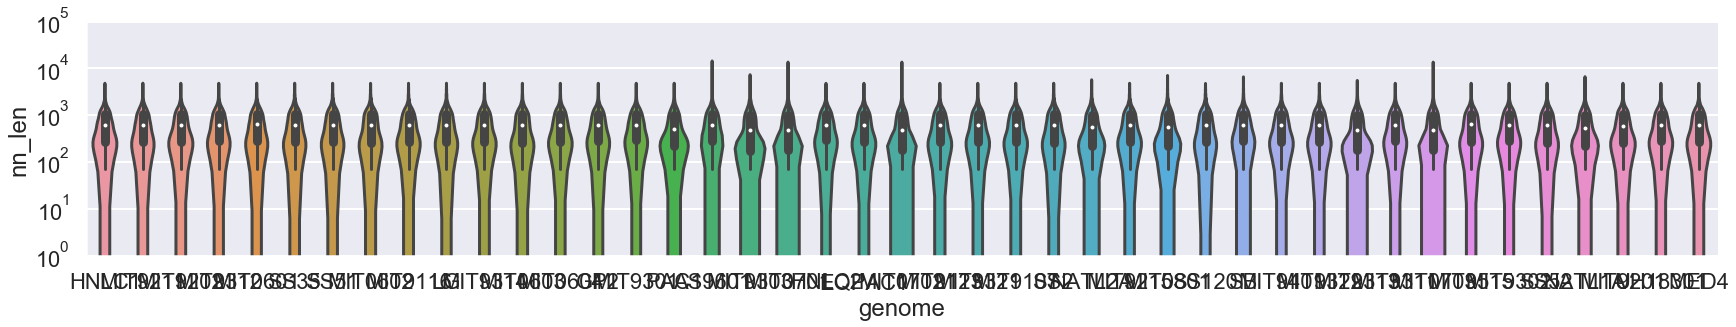

In [44]:
g =sns.catplot(data=genome_df, x='genome',
               y='nn_len', kind='violin', aspect=5 )
g.set(yscale='log')

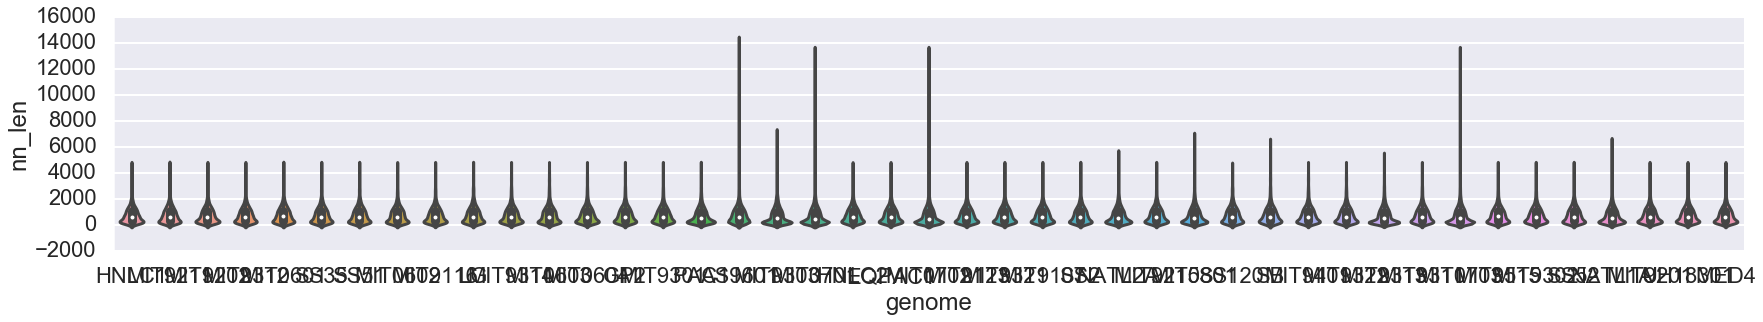

In [45]:
g =sns.catplot(data=genome_df, x='genome',
               y='nn_len', kind='violin', aspect=5 )
#g.set(yscale='log')

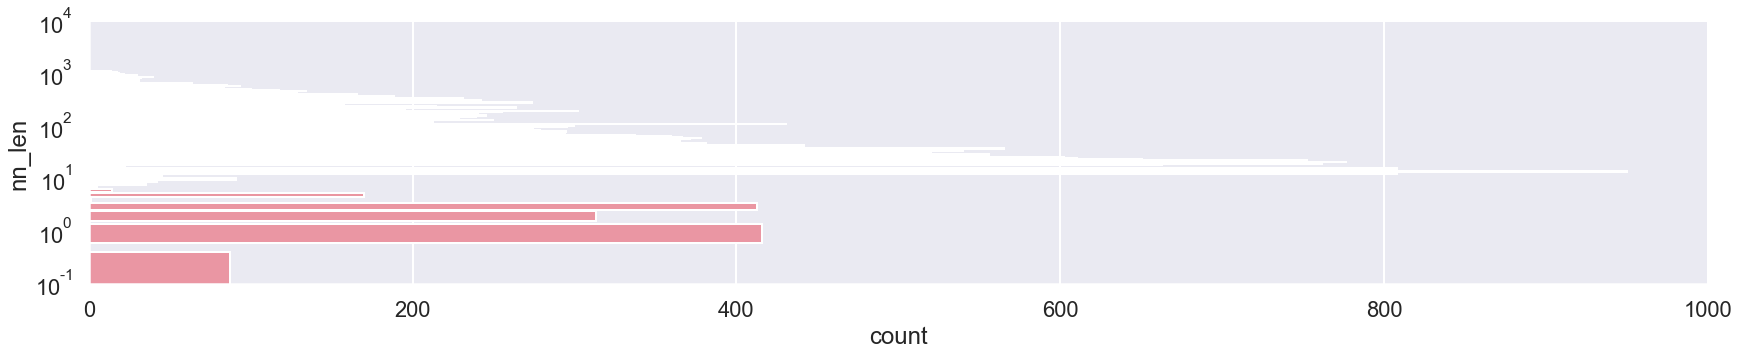

In [27]:
g =sns.catplot(data=genome_df.sort_values('nn_len'), #hue='genome',
               y='nn_len', kind='count', aspect=5 )
g.set(yscale='log')

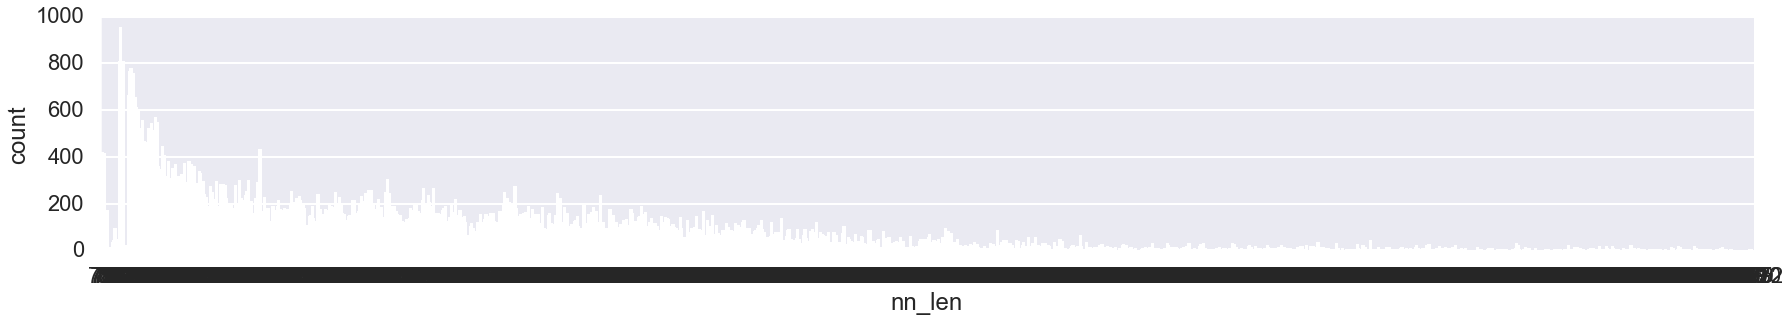

In [29]:
g =sns.catplot(data=genome_df.sort_values('nn_len'), #hue='genome',
               x='nn_len', kind='count', aspect=5 )
#g.set(yscale='log')

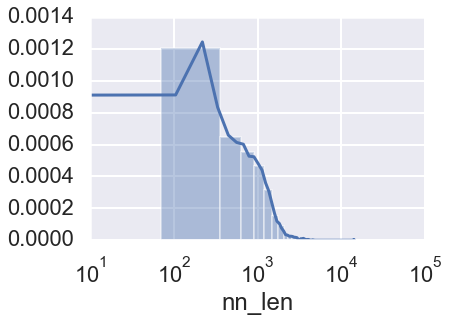

In [39]:
g =sns.distplot(genome_df['nn_len']), #hue='genome')
               #x='nn_len', kind='count', aspect=5 )
plt.xscale('log')

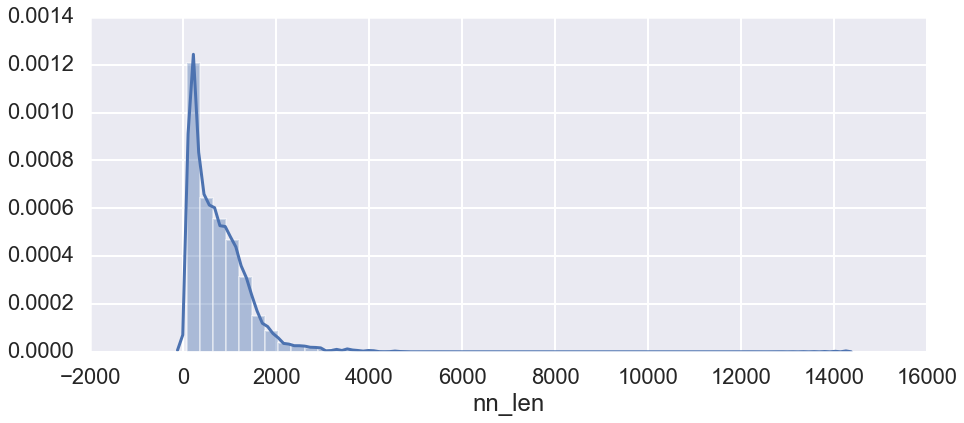

In [114]:
plt.figure(figsize=(15,6))
g =sns.distplot(genome_df['nn_len']), #hue='genome')
               #x='nn_len', kind='count', aspect=5 )
#plt.xscale('log')

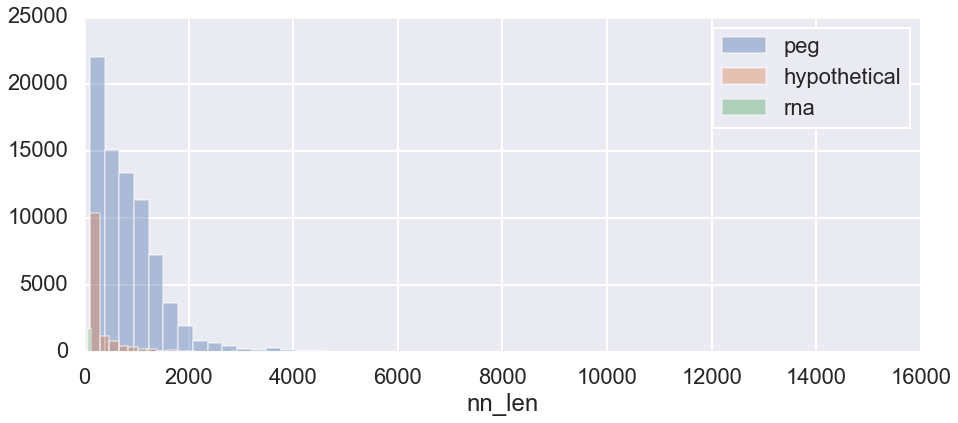

In [144]:
plt.figure(figsize=(15,6))
for i in ['peg', 'hypothetical', 'rna']:
    sns.distplot(genome_df.loc[genome_df.Type == i]['nn_len'], label=i, kde=False)
plt.legend()

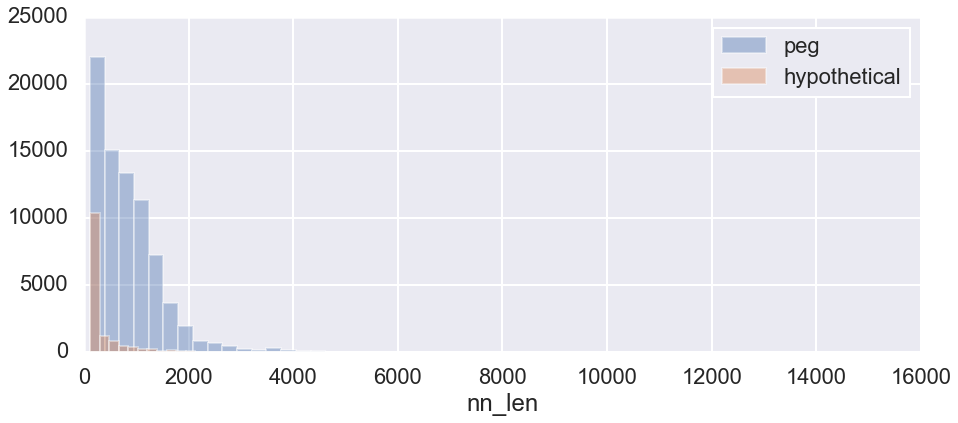

In [138]:
plt.figure(figsize=(15,6))
for i in ['peg', 'hypothetical', ]:
    sns.distplot(genome_df.loc[genome_df.Type == i]['nn_len'], label=i, kde=False)
plt.legend()

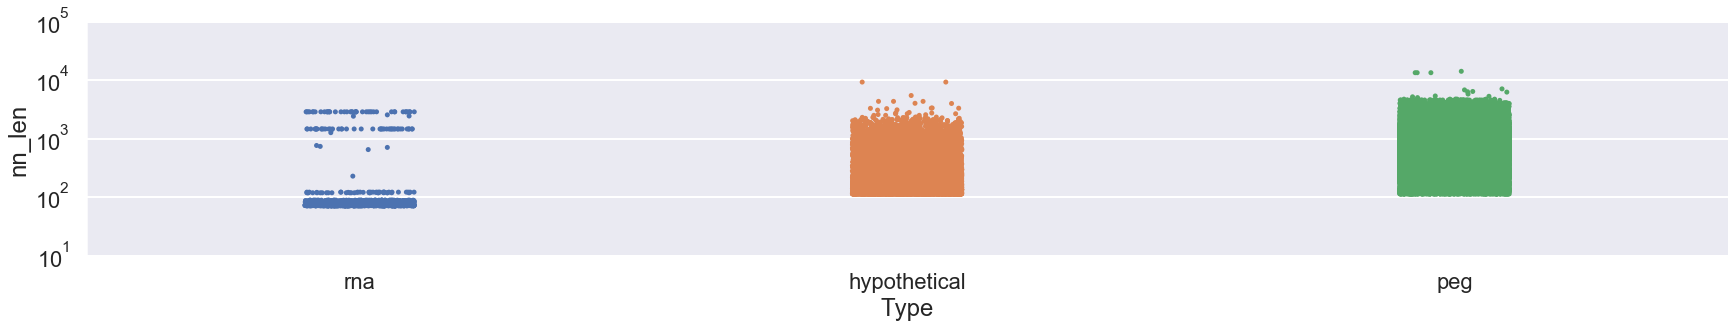

In [39]:
g =sns.catplot(data=genome_df.sort_values('nn_len'), x='Type', y='nn_len', #kind='swarm', #hue='genome', 
               aspect=5)
g.set(yscale='log')

In [23]:
bins = [0, 50, 100, 150, 200, 250, 300, 400]
pd.cut(genome_df.nn_len, bins).value_counts()

(100, 150]    9155
(150, 200]    7269
(300, 400]    7165
(200, 250]    5377
(250, 300]    4580
(50, 100]     1633
(0, 50]          0
Name: nn_len, dtype: int64

In [24]:
genome_df['nn_len_bin'] = pd.cut(genome_df.nn_len, bins)

In [25]:
genome_df['nn_len_bin'].value_counts()

(100, 150]    9155
(150, 200]    7269
(300, 400]    7165
(200, 250]    5377
(250, 300]    4580
(50, 100]     1633
(0, 50]          0
Name: nn_len_bin, dtype: int64

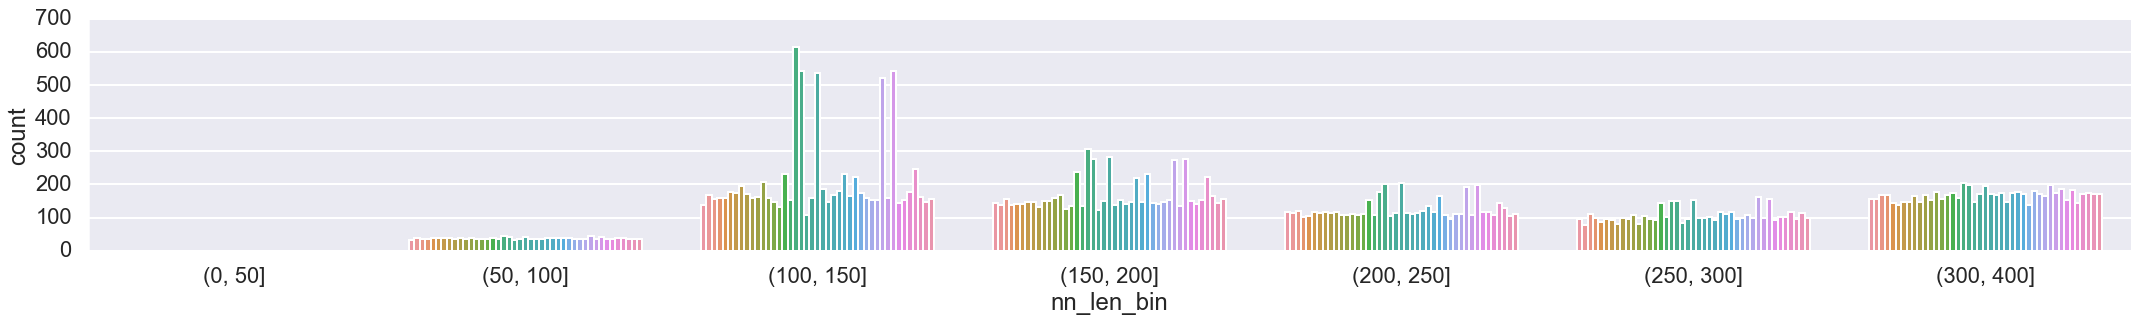

In [26]:
sns.catplot(data=genome_df, hue='genome', x='nn_len_bin', kind='count', legend=False, aspect=6)

In [27]:
bin_df = genome_df.groupby(['genome', 'clade', 'Type', 'nn_len_bin'])['nn_len'].count().reset_index()

In [28]:
bin_df.rename(columns={'nn_len': 'count'}, inplace=True)

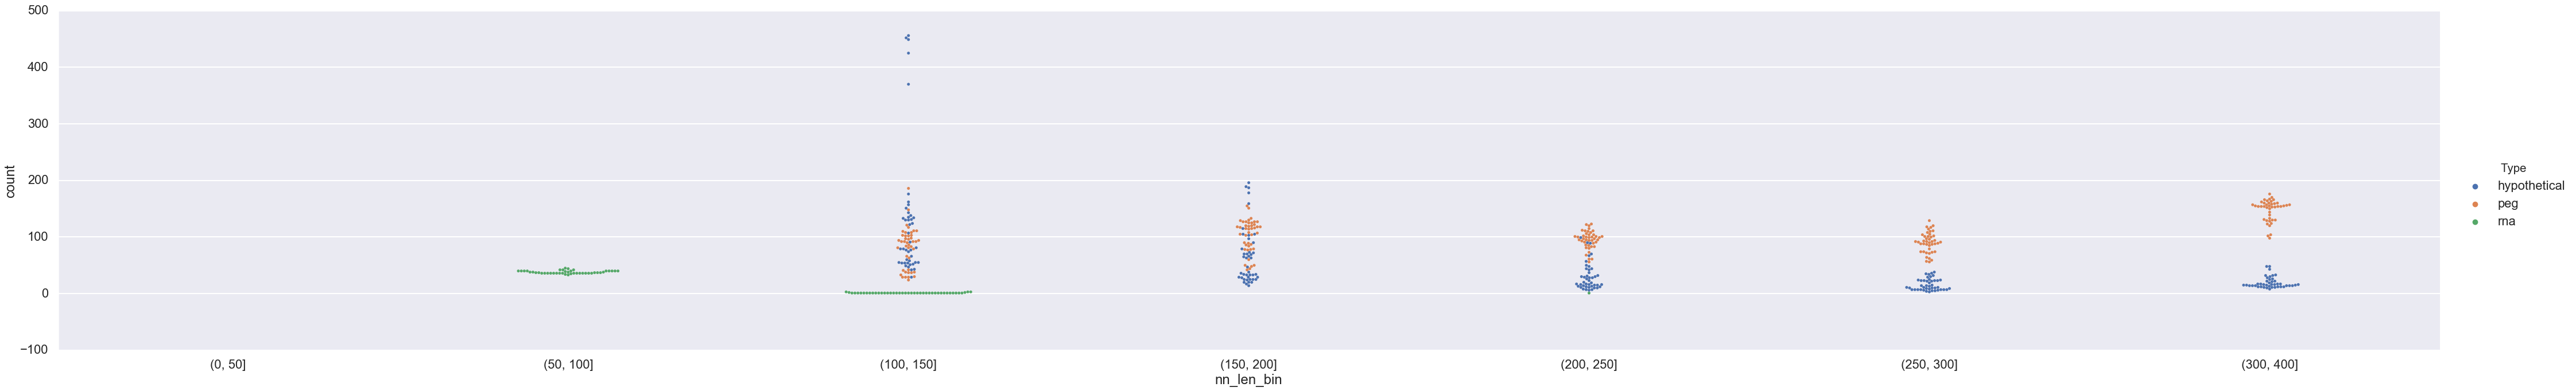

In [29]:
sns.catplot(data=bin_df, x='nn_len_bin', y='count', hue='Type', height=10, aspect=6, kind='swarm')

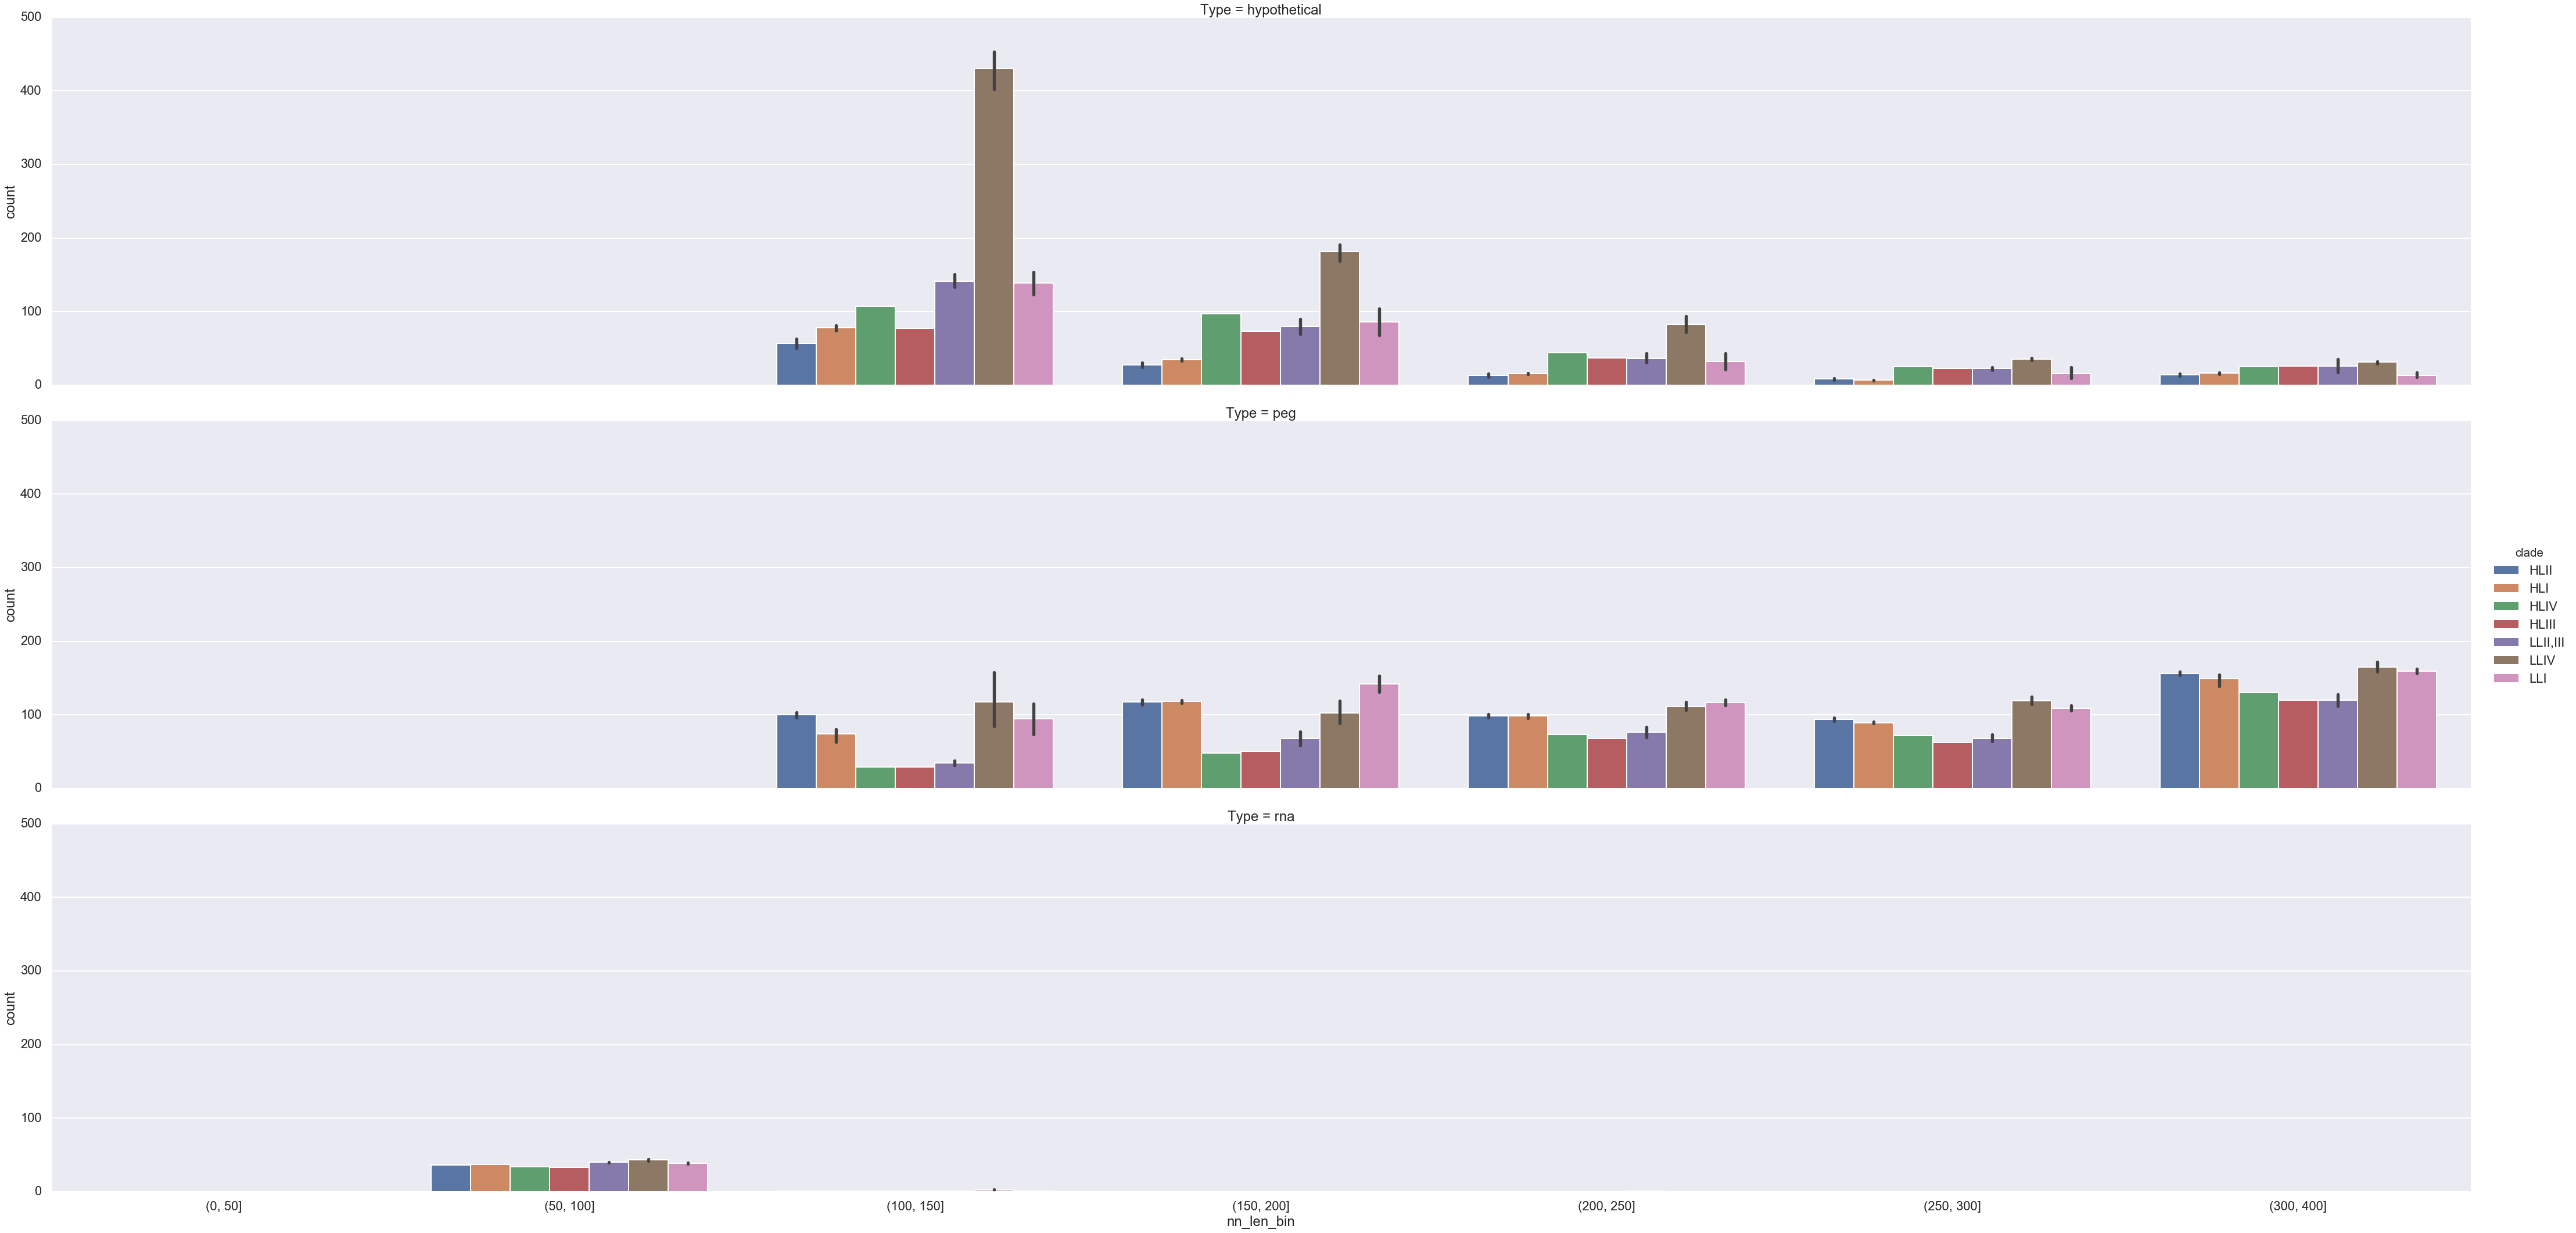

In [30]:
sns.catplot(data=bin_df, x='nn_len_bin', y='count', row='Type',
            height=10, aspect=6, kind='bar', hue='clade'
           )

In [64]:
bin_df.nn_len_bin.head()

0    (100, 150]
1    (150, 200]
2    (200, 250]
3    (250, 300]
4    (300, 400]
Name: nn_len_bin, dtype: category
Categories (20, interval[int64]): [(0, 50] < (50, 100] < (100, 150] < (150, 200] ... (1300, 1500] < (1500, 2000] < (2000, 5000] < (5000, 15000]]

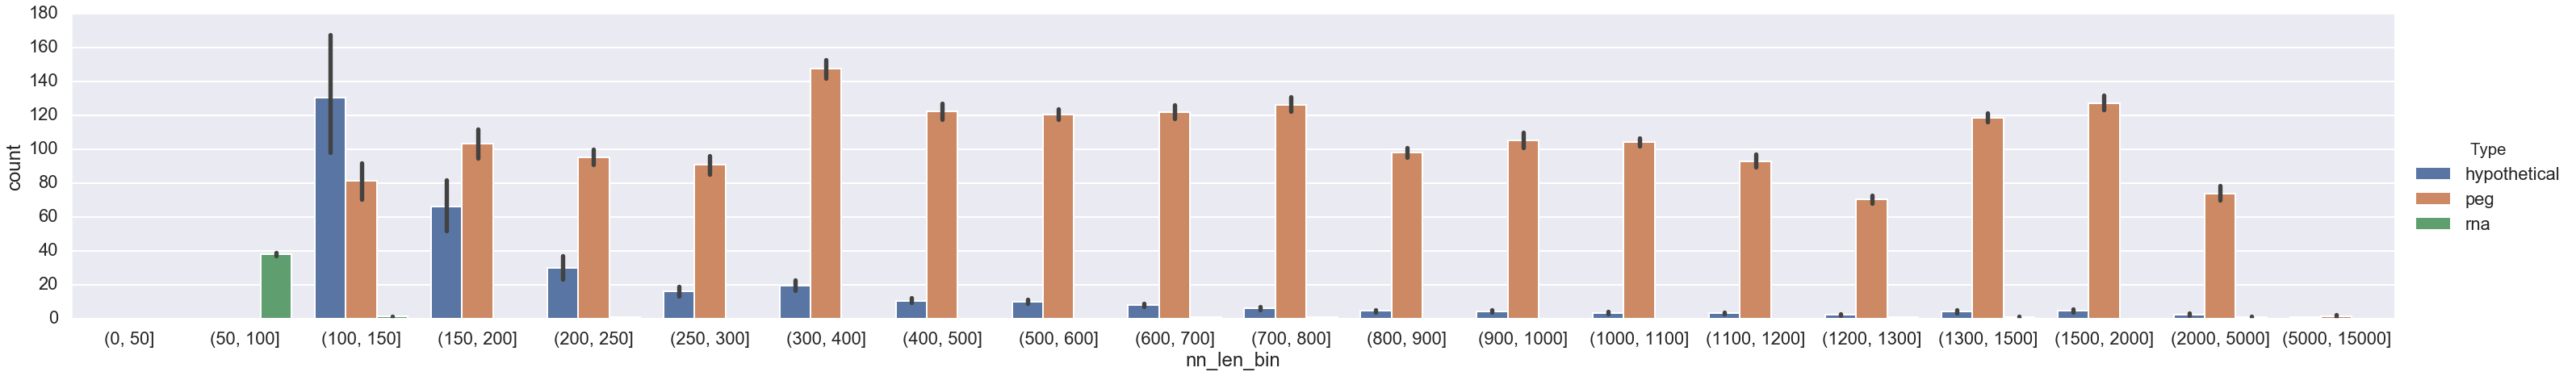

In [171]:
sns.catplot(data=bin_df, x='nn_len_bin', y='count', hue='Type', height=7, aspect=6, kind='bar')

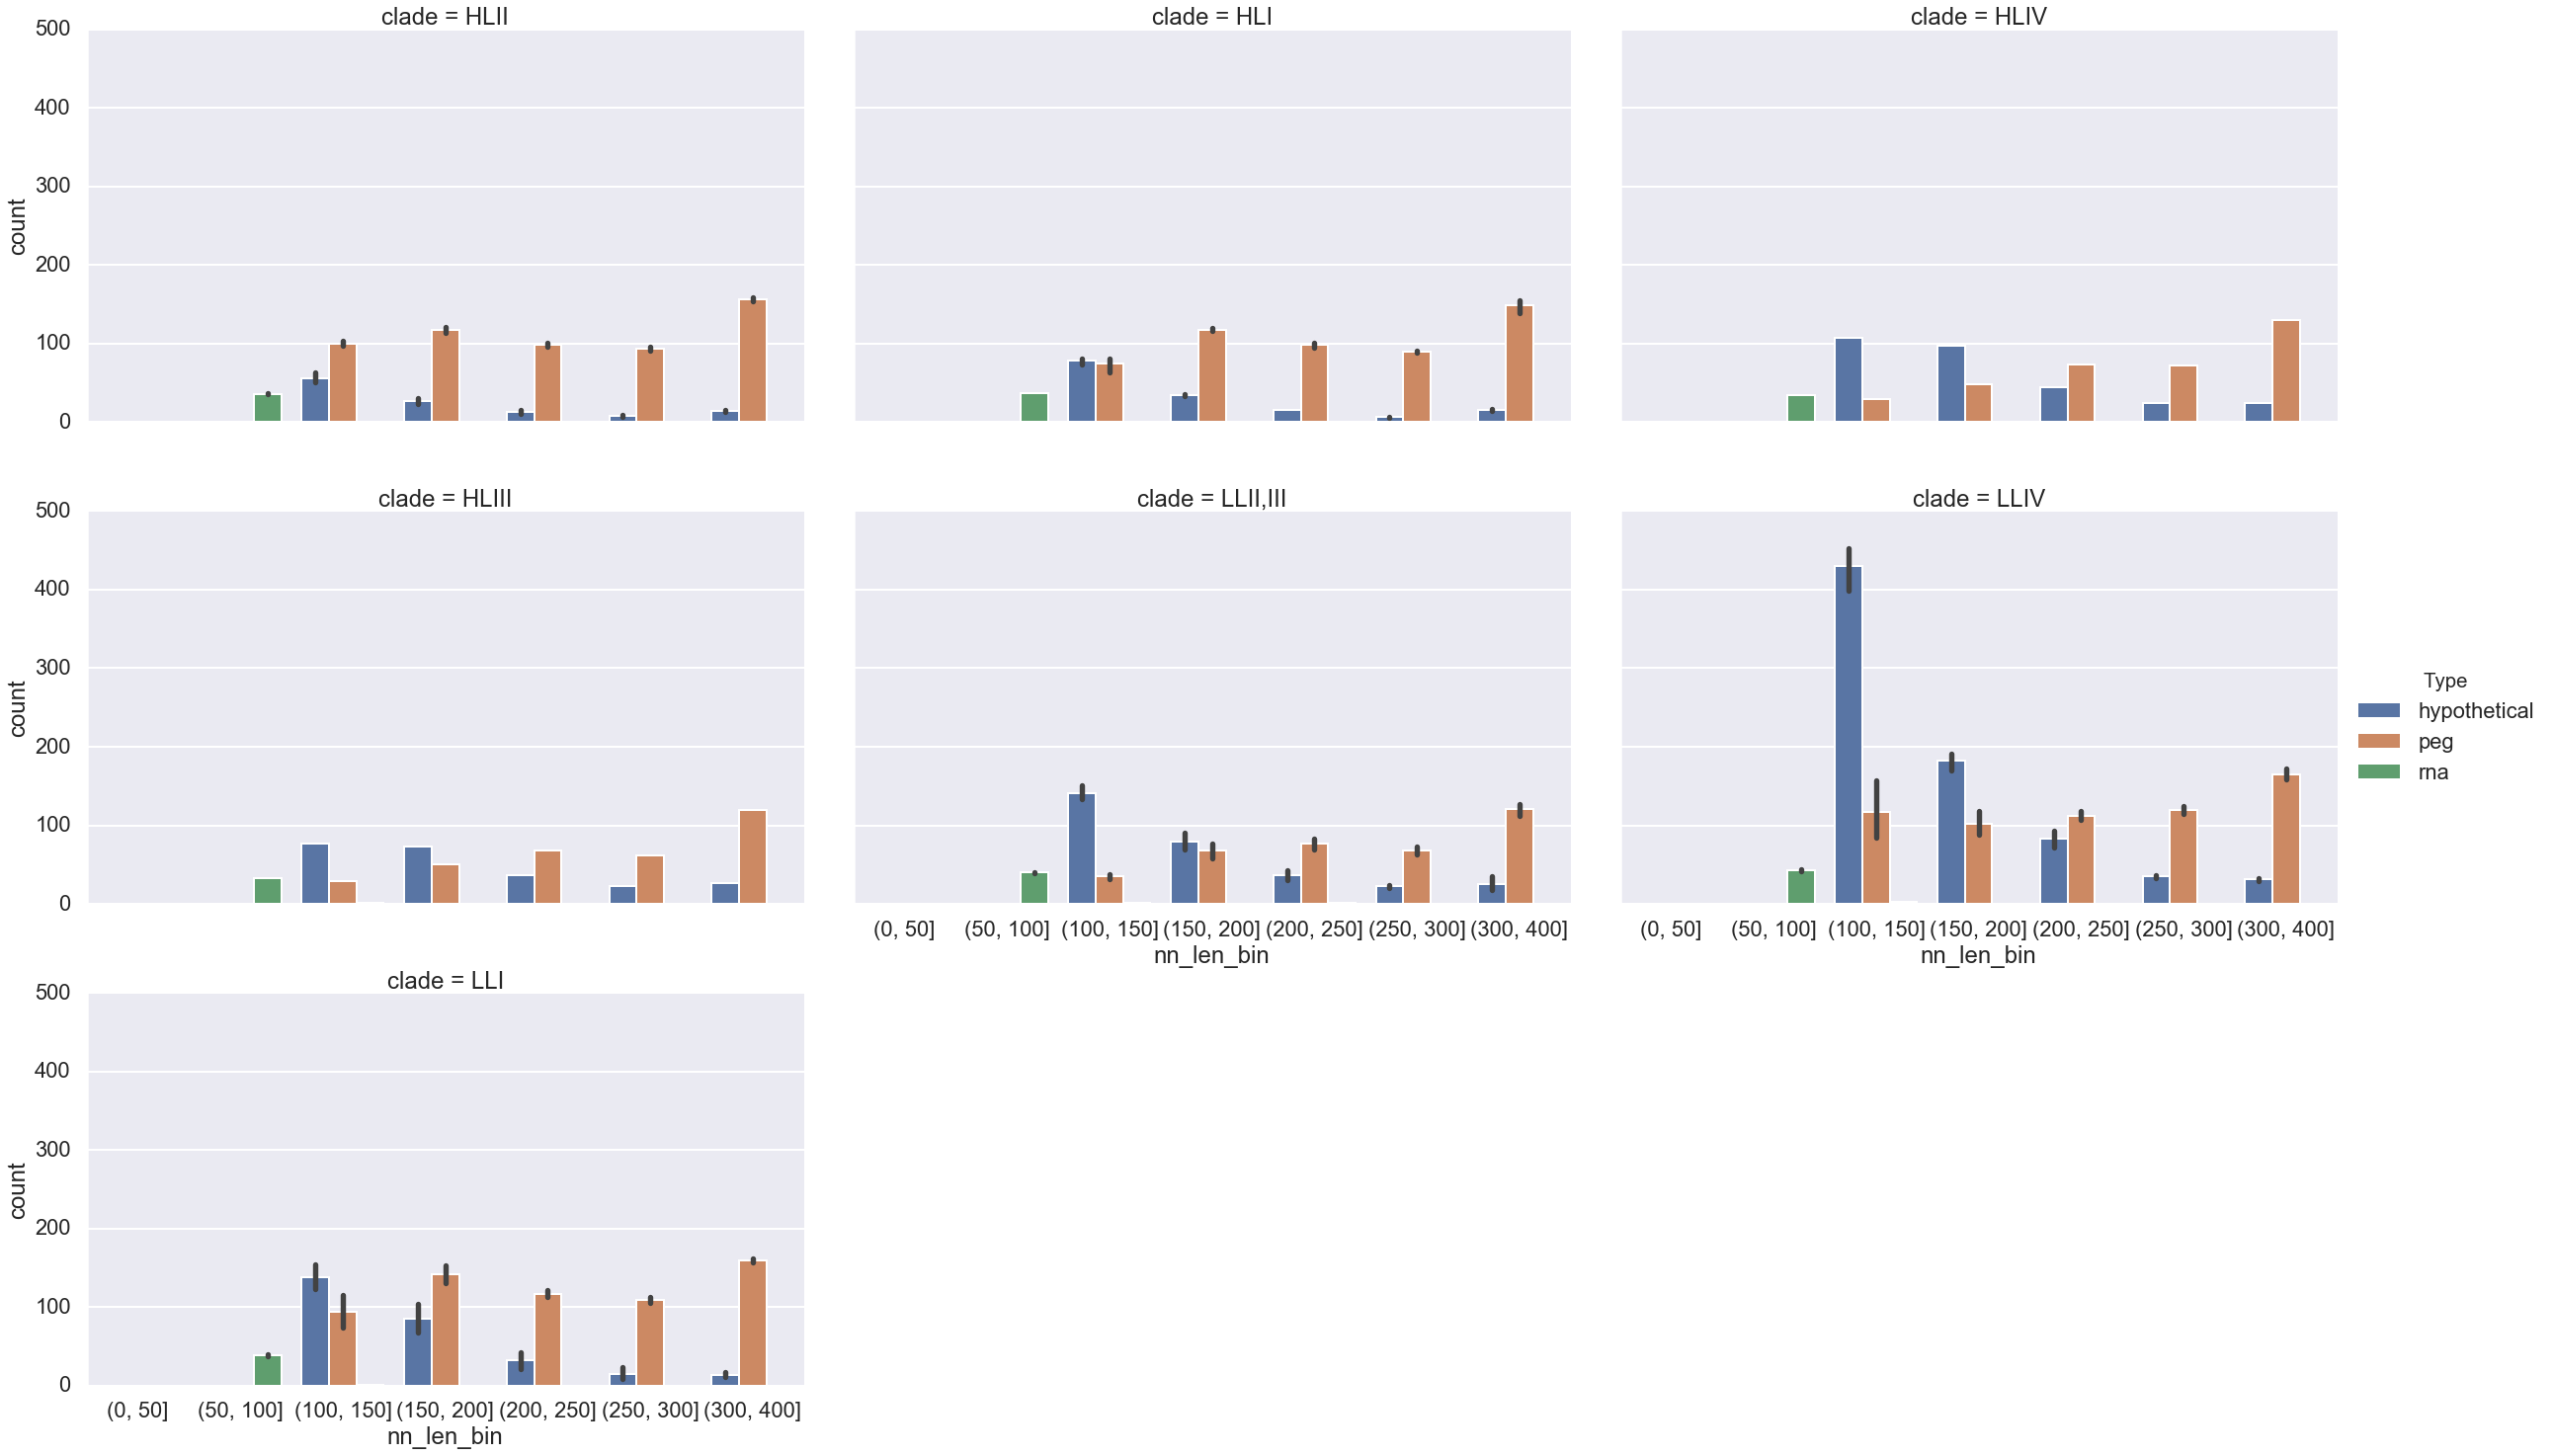

In [35]:
sns.catplot(data=bin_df, x='nn_len_bin', y='count', hue='Type', height=7, aspect=1.6, kind='bar', col='clade', col_wrap=3)

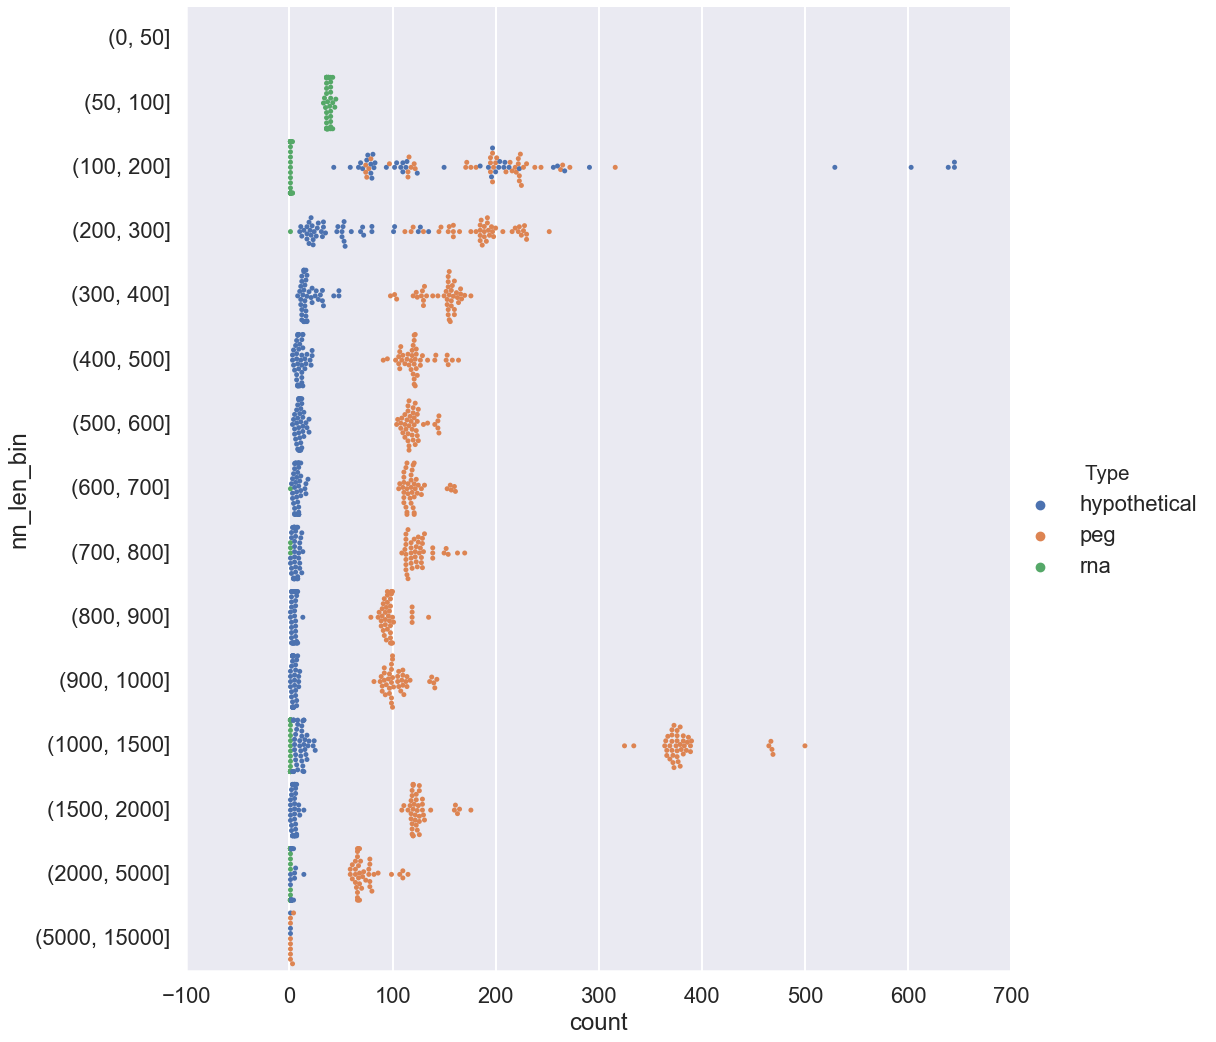

In [156]:
sns.catplot(data=bin_df, y='nn_len_bin', x='count', hue='Type', aspect=1, height=15,
            kind='swarm')

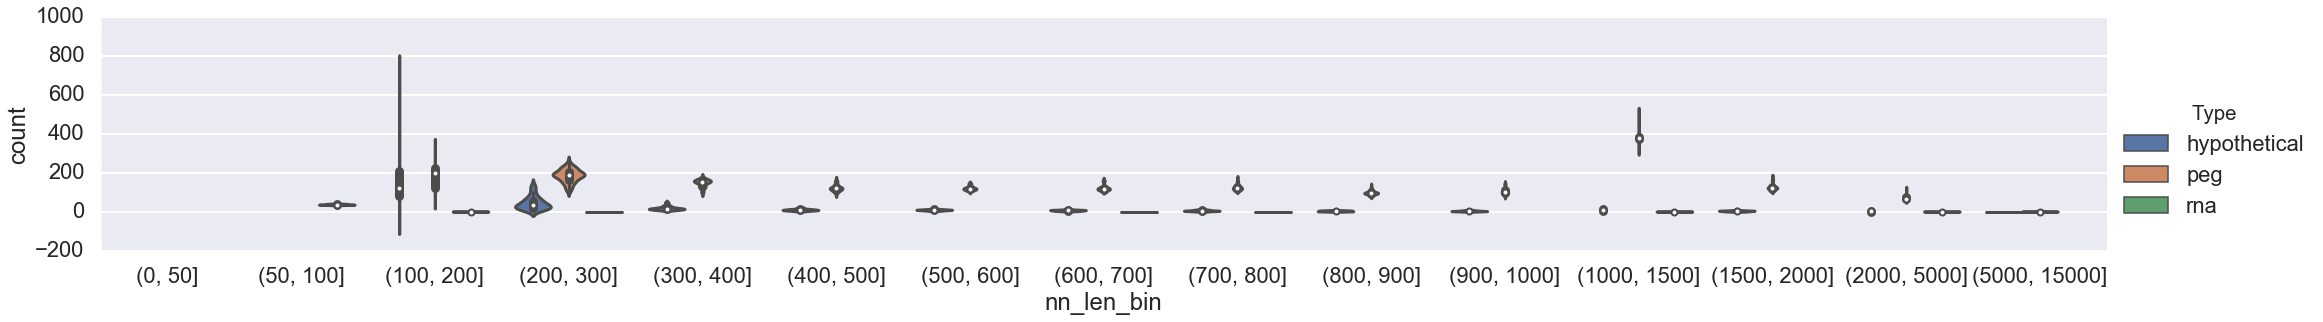

In [153]:
sns.catplot(data=bin_df, x='nn_len_bin', y='count',  hue='Type', aspect=6, kind='violin')

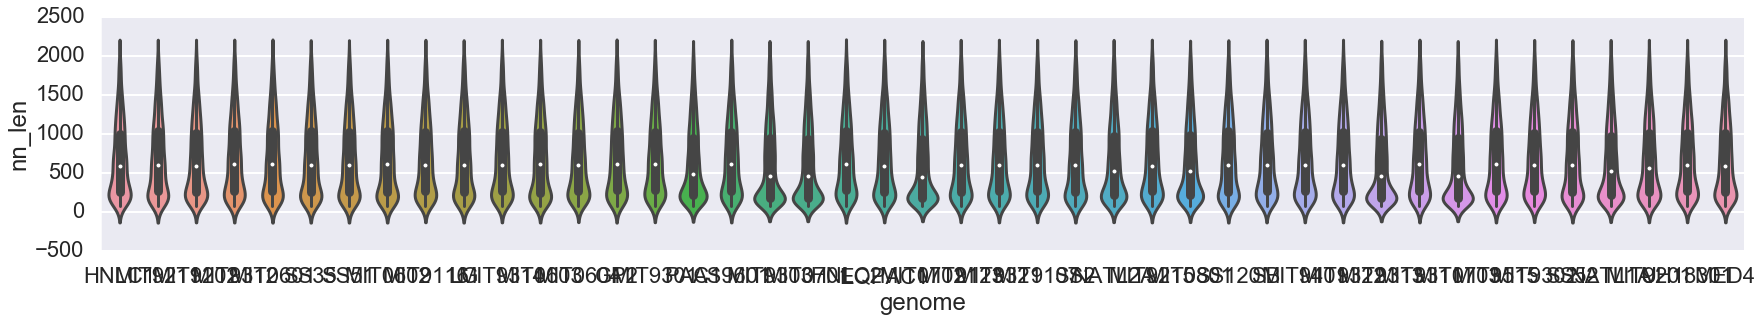

In [92]:
g =sns.catplot(data=genome_df.loc[genome_df.nn_len < 2000], x='genome',
               y='nn_len', kind='violin', aspect=5 )
#g.set(yscale='log')

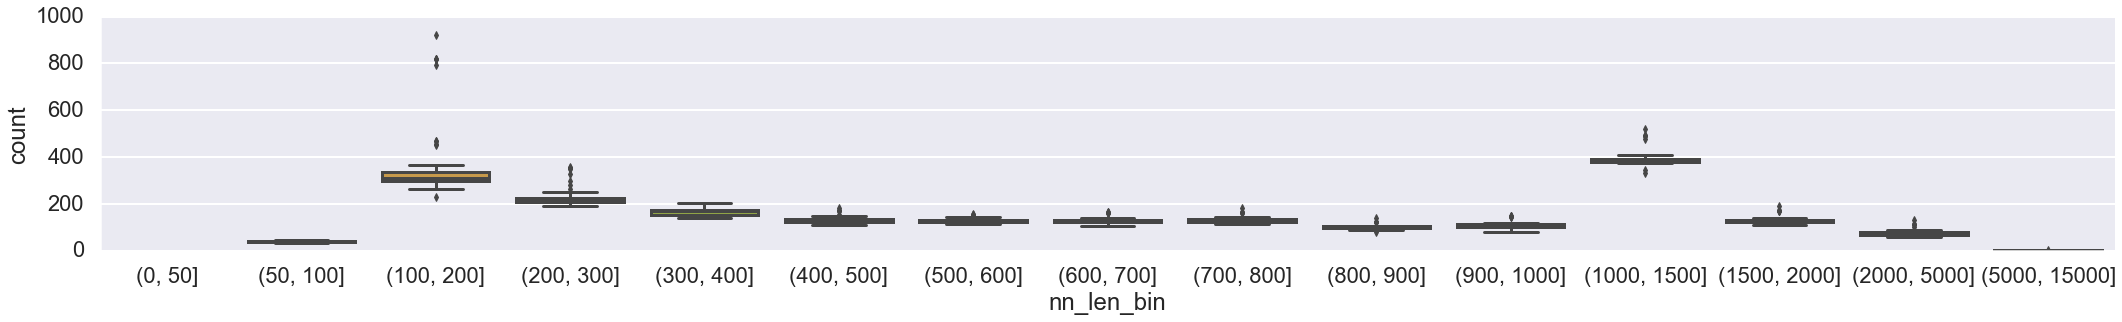

In [88]:
sns.catplot(data=bin_df, x='nn_len_bin', y='count', aspect=6, kind='box')

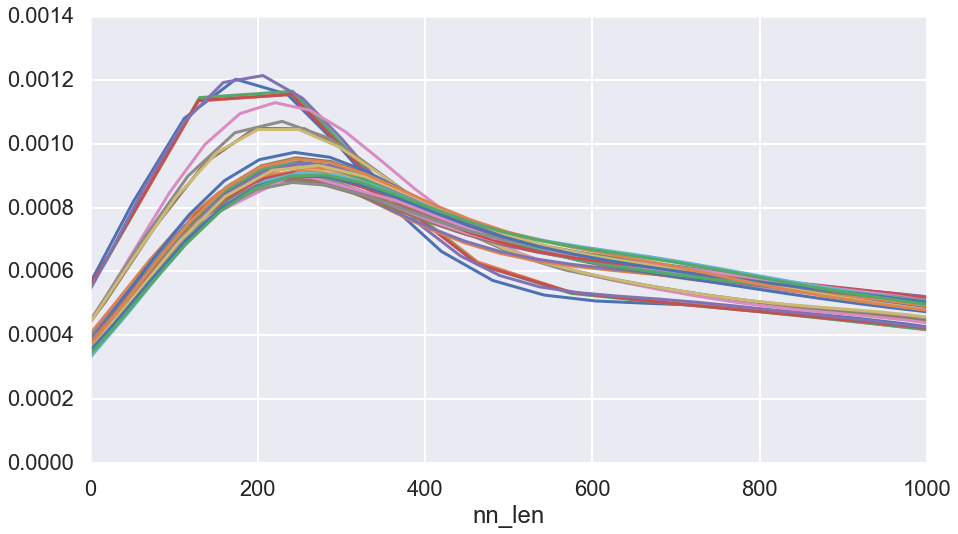

In [99]:
plt.figure(figsize=(15,8))
genomes_list = genome_df.genome.value_counts().index
plt.xlim(0, 1000)
for g in genomes_list:
    sns.distplot(genome_df.loc[genome_df.genome == g].nn_len, hist=False )

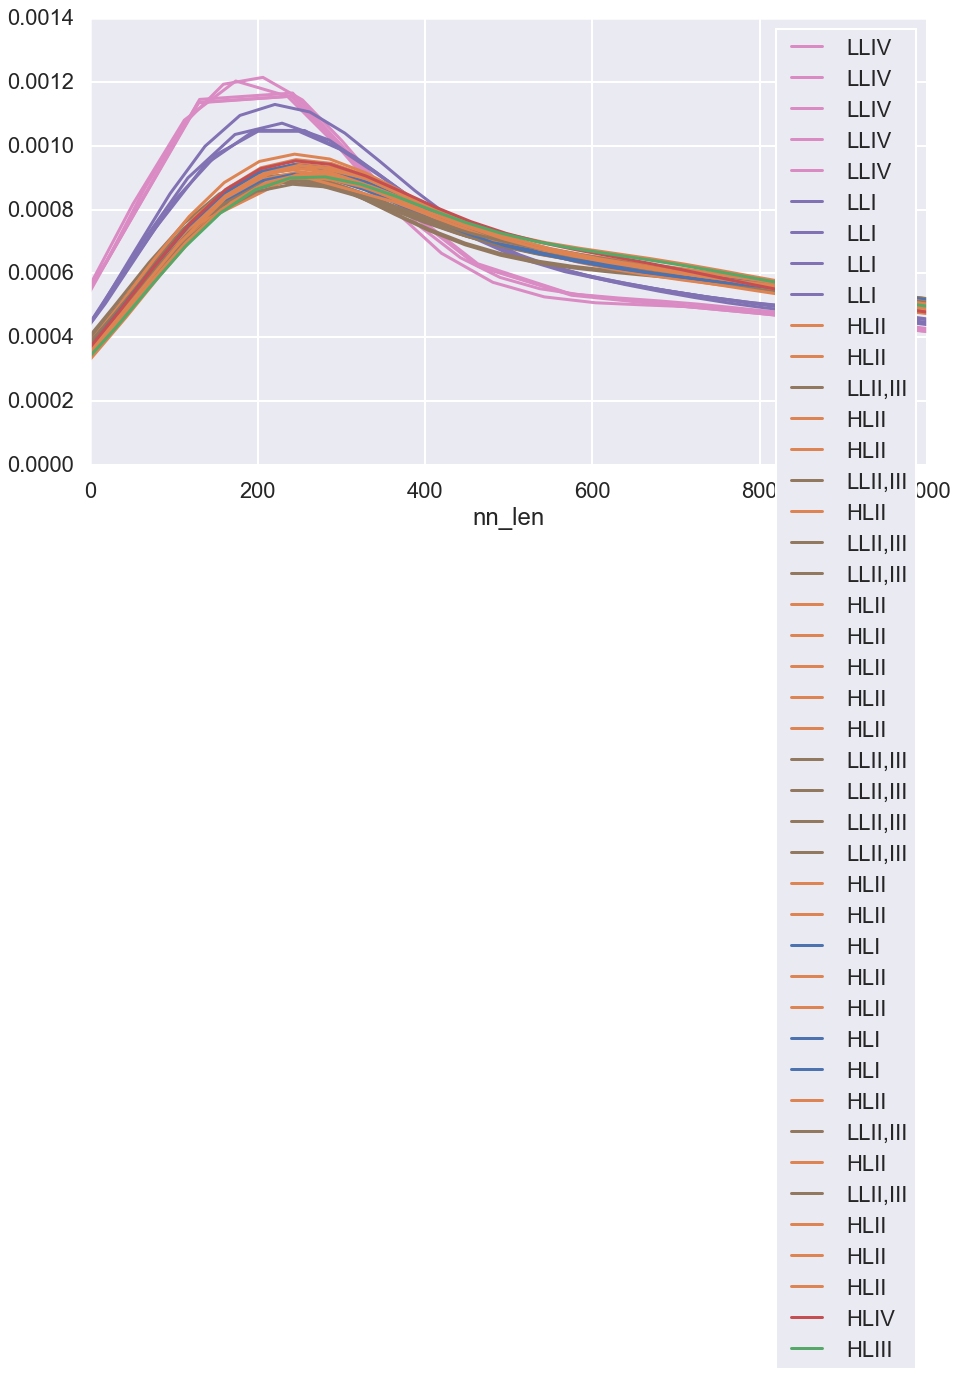

In [39]:
plt.figure(figsize=(15,8))
genomes_list = genome_df.genome.value_counts().index
ncolors = clades.Clade.nunique()
pallete = sns.color_palette(n_colors=ncolors)
colors_dict = {c : pallete[i] for i,c in enumerate(clades.Clade.unique())}

plt.xlim(0, 1000)
for g in genomes_list:
    clade = clades.loc[clades.Name == g, 'Clade'][0]
    c = colors_dict[clade]
    sns.distplot(genome_df.loc[genome_df.genome == g].nn_len, hist=False , color=c, label=clade
                )

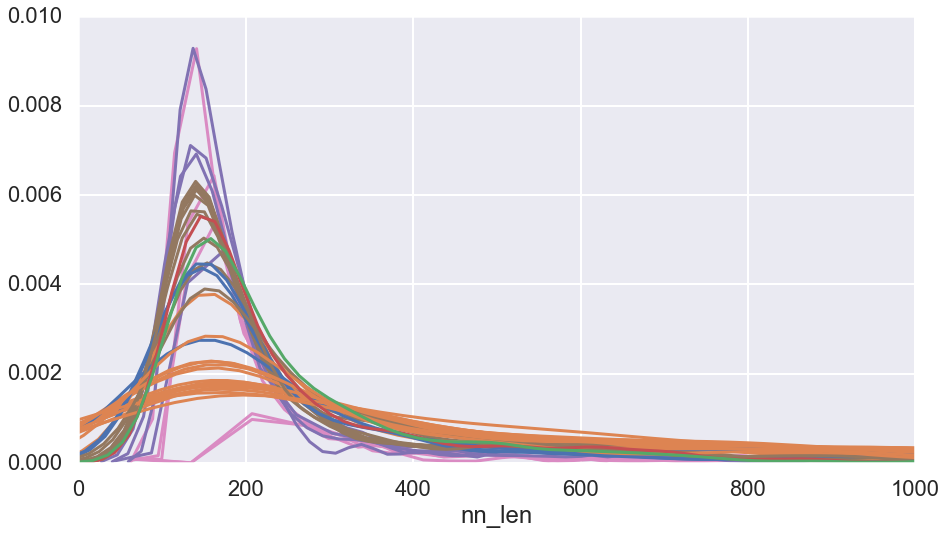

In [78]:
plt.figure(figsize=(15,8))
genomes_list = genome_df.genome.value_counts().index
ncolors = clades.Clade.nunique()
pallete = sns.color_palette(n_colors=ncolors)
colors_dict = {c : pallete[i] for i,c in enumerate(clades.Clade.unique())}

plt.xlim(0, 1000)
for g in genomes_list:
    clade = clades.loc[clades.Name == g, 'Clade'][0]
    c = colors_dict[clade]
    sns.distplot(genome_df.loc[(genome_df.genome == g) & (genome_df.Type == 'hypothetical')].nn_len, 
                 hist=False , color=c)

In [40]:
bin_df.loc[bin_df.Type == 'hypothetical'].nlargest(n=10, columns='count')

,genome,clade,Type,nn_len_bin,count
132,MIT0701,LLIV,hypothetical,"(100, 150]",456
156,MIT0703,LLIV,hypothetical,"(100, 150]",452
144,MIT0702,LLIV,hypothetical,"(100, 150]",449
288,MIT9303,LLIV,hypothetical,"(100, 150]",425
324,MIT9313,LLIV,hypothetical,"(100, 150]",370
145,MIT0702,LLIV,hypothetical,"(150, 200]",196
133,MIT0701,LLIV,hypothetical,"(150, 200]",189
157,MIT0703,LLIV,hypothetical,"(150, 200]",187
289,MIT9303,LLIV,hypothetical,"(150, 200]",178
108,MIT0603,"LLII,III",hypothetical,"(100, 150]",176


(0, 4000)

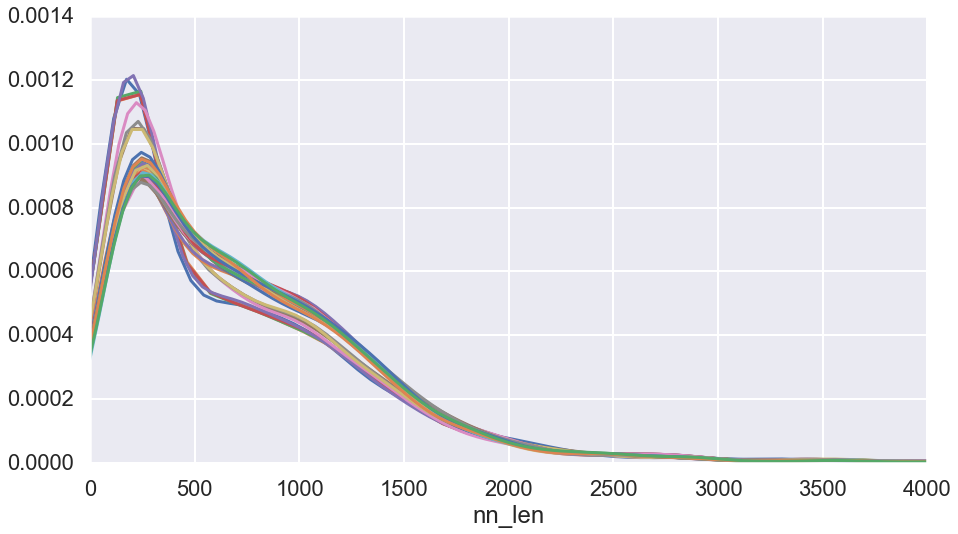

In [105]:
plt.figure(figsize=(15,8))
genomes_list = genome_df.genome.value_counts().index
for g in genomes_list:
    sns.distplot(genome_df.loc[genome_df.genome == g].nn_len, hist=False )
plt.xlim(0, 4000)


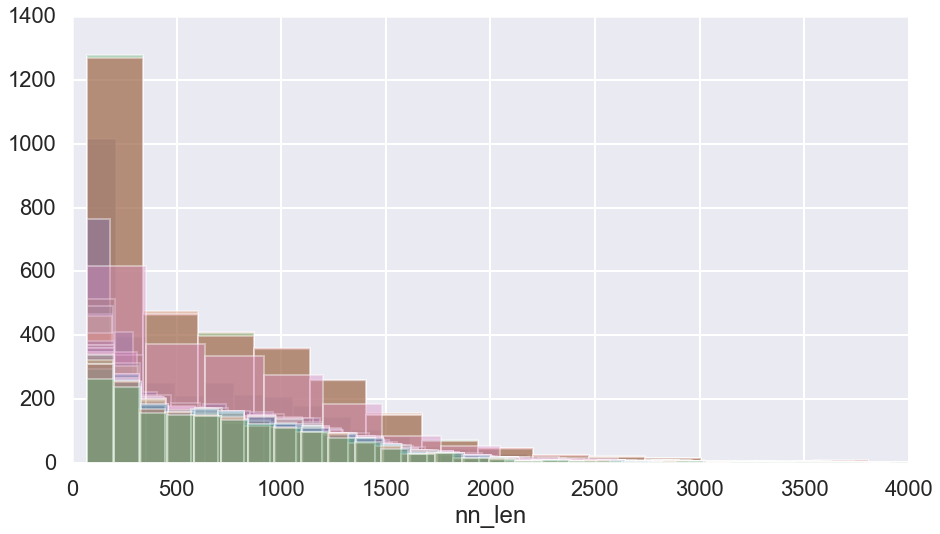

In [106]:
plt.figure(figsize=(15,8))
genomes_list = genome_df.genome.value_counts().index
plt.xlim(0, 4000)
for g in genomes_list:
    sns.distplot(genome_df.loc[genome_df.genome == g].nn_len, kde=False )

[None]

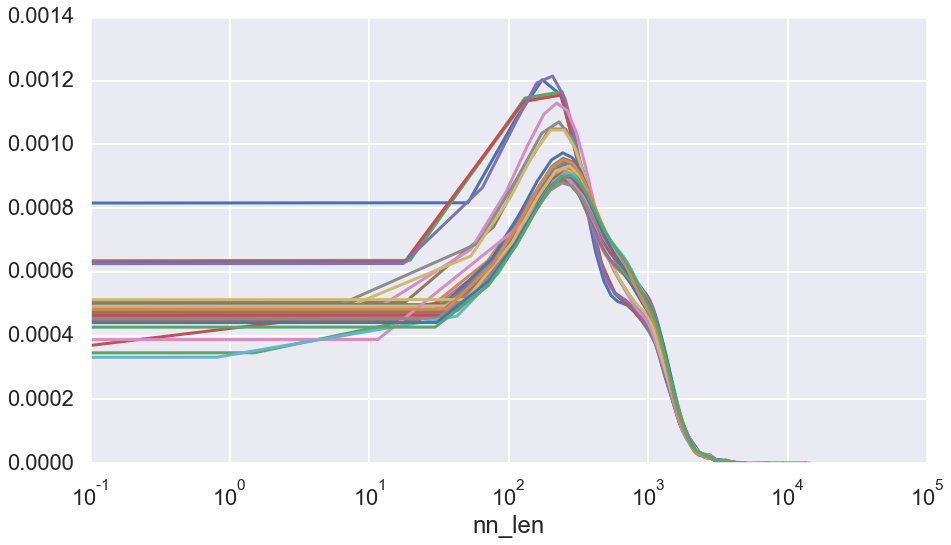

In [103]:
plt.figure(figsize=(15,8))
genomes_list = genome_df.genome.value_counts().index
#plt.xlim(0, 1000)
for g in genomes_list:
    ax=sns.distplot(genome_df.loc[genome_df.genome == g].nn_len, hist=False )
ax.set(xscale='log')

In [107]:
genome_df.head()

,contig_id,gene_id,feature_id,type,location,start,stop,strand,function,aliases,figfam,evidence_codes,nucleotide_sequence,aa_sequence,genome,nn_len,number_of_genes,nn_len_bin
7646,gi|336327441|gb|GL947594.1|,NaN,fig|1218.243.rna.34,rna,gi|336327441|gb|GL947594.1|_1450346_1450416,1450346,1450416,+,tRNA-Cys-GCA,NaN,NaN,NaN,ggcggcatggccaagtggtaaggcagaggattgcaaatcctttatc...,NaN,HNLC1,71,NaN,"(50, 100]"
45373,MIT9211,NaN,fig|1218.86.rna.40,rna,MIT9211_1534133_1534203,1534133,1534203,+,tRNA-Cys-GCA,NaN,NaN,isu;tRNAs,ggcggcatggccaagtggtaaggcagaggattgcaaatcctttatc...,NaN,MIT9211,71,NaN,"(50, 100]"
7420,gi|336327441|gb|GL947594.1|,NaN,fig|1218.243.rna.27,rna,gi|336327441|gb|GL947594.1|_1248775_1248705,1248775,1248705,-,tRNA-Gly-TCC,NaN,NaN,NaN,gcgggcgtagtttagtggtaaaacctcagccttccaagctgatgat...,NaN,HNLC1,71,NaN,"(50, 100]"
41918,P9202,NaN,fig|1218.85.rna.9,rna,P9202_340508_340438,340508,340438,-,tRNA-Gly-TCC,NaN,NaN,NaN,gcgggcgtggtttagtggtaaaacctcagccttccaagctgaagat...,NaN,MIT9202,71,NaN,"(50, 100]"
58831,MIT9312,NaN,fig|1218.90.rna.36,rna,MIT9312_1568001_1568071,1568001,1568071,+,tRNA-Cys-GCA,NaN,NaN,isu;tRNAs,ggcggcatggccaagtggtaaggcagaggattgcaaatcctttatc...,NaN,MIT9312,71,NaN,"(50, 100]"


In [111]:
genome_df.is_hypothetical.value_counts()

False    79089
True     13847
Name: is_hypothetical, dtype: int64

In [ ]:
sns.relplot(data=genome_df, x='')